<a href="https://colab.research.google.com/github/hkuennemann/StrataScratch/blob/main/23andME_project/23andMe_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Data Analysis [23andMe]

Note: This data project has been used as a take-home assignment in the recruitment process for the data science positions at 23andMe.

## Assignment
Please answer the questions below based on the data provided:

1. Plot daily sales for all 50 weeks.
2. It looks like there has been a sudden change in daily sales. What date did it occur?
3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).
5. Assume a given day is divided into four dayparts:
  - night (12:00AM - 6:00AM),
  - morning (6:00AM - 12:00PM),
  - afternoon (12:00PM - 6:00PM),
  - evening (6:00PM - 12:00AM).

  What is the percentage of sales in each daypart over all 50 weeks?

## Data Description
The *datasets/* directory contains fifty CSV files (one per week) of timestamped sales data. Each row in a file has two columns:

- `sale_time` - The timestamp on which the sale was made e.g. 2012-10-01 01:42:22
- `purchaser_gender` - The gender of the person who purchased (male or female)


In [ ]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import datetime as dt
import glob

# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Hyperparameters
FIGSIZE = (12, 6)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get a list of all CSV files in a directory
csv_files = glob.glob('drive/MyDrive/23andMe_datasets/*.csv')

# Create an empty dataframe to store the combined data
combined_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    combined_df = pd.concat([combined_df, df])

# Convert sale_time to datetime
combined_df['sale_time'] = pd.to_datetime(combined_df.sale_time)

# Have a first look at the data
display(combined_df.head())

,sale_time,purchaser_gender
0,2012-12-24 01:06:36,male
1,2012-12-24 01:24:41,female
2,2012-12-24 02:27:53,female
3,2012-12-24 02:36:06,male
4,2012-12-24 02:36:34,male


## 1. Plot daily sales for all 50 weeks

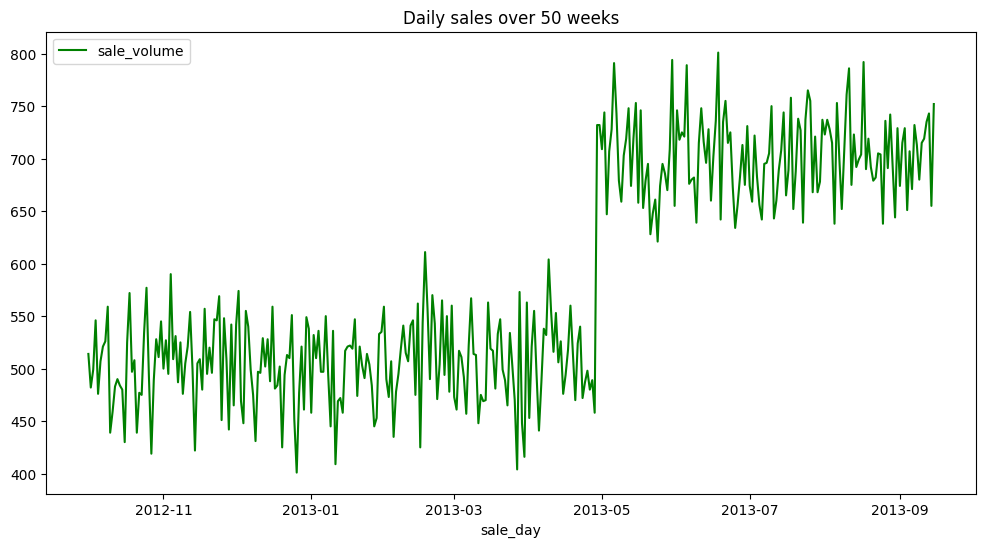

In [ ]:
# Group data by sale_time and calculate sale volume for each day
daily_sales = combined_df.groupby(combined_df['sale_time'].dt.date)\
                         .size()\
                         .to_frame(name='sale_volume')\
                         .reset_index()\
                         .sort_values(by = 'sale_time')\
                         .rename(columns={'sale_time':'sale_day'})

# Put sale_day into index for plotting
daily_sales.index = daily_sales['sale_day']
daily_sales.drop(columns=['sale_day'], inplace=True)

#  plot daily sales for all 50 weeks
daily_sales.plot(figsize=FIGSIZE, title = 'Daily sales over 50 weeks', color = 'g')
plt.show()

## 2. It looks like there has been a sudden change in daily sales. What date did it occur?

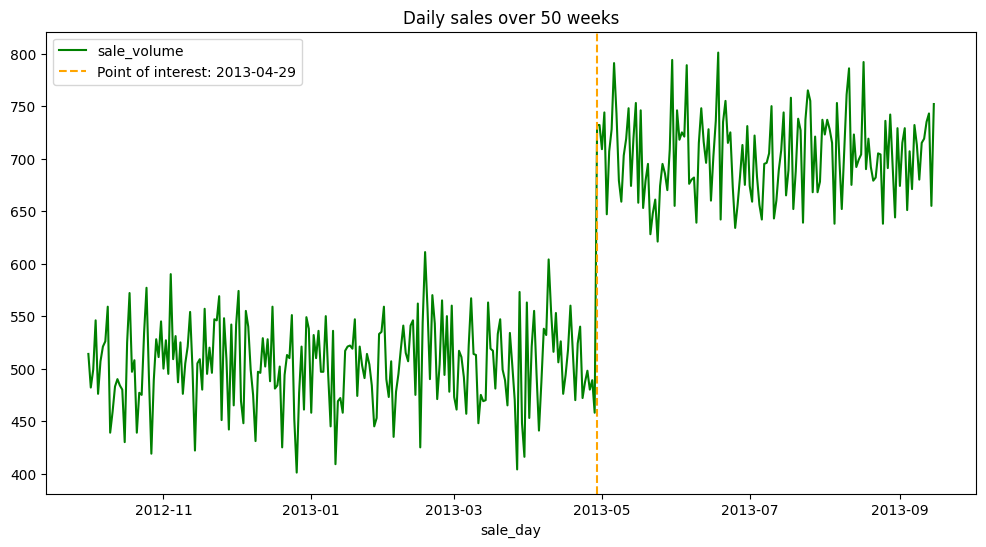


The date of the sudden change in daily sales is: 2013-04-29


In [ ]:
# Get cut off point by taking the first value with over 700 sales
cut_off_point = daily_sales[daily_sales.sale_volume > 700].index.min()

# Creating the plot (just like before)
daily_sales.plot(figsize=FIGSIZE, title = 'Daily sales over 50 weeks', color = 'g')

# Adding a vertical line at the cut off point
plt.axvline(pd.to_datetime(cut_off_point), color='orange', linestyle='--', label=f'Point of interest: {cut_off_point}')
plt.legend()
plt.show()

# Printing out the date of the sudden change in daily sales
print(f'\nThe date of the sudden change in daily sales is: {cut_off_point}')

## 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [ ]:
# Split the data based on the date
before_cut_off_point = daily_sales.loc[daily_sales.index < cut_off_point, 'sale_volume']
after_cut_off_point = daily_sales.loc[daily_sales.index >= cut_off_point, 'sale_volume']

# Check normality using the Shapiro-Wilk test
_, p_before = shapiro(before_cut_off_point)
_, p_after = shapiro(after_cut_off_point)

# If both p-values > 0.05, the data is normally distributed
print(f'Shapiro-Wilk test p-value for data before {cut_off_point}: {p_before}')
if p_before > 0.05:
  print('Thus, the data is normally distributed.\n')
else:
  print('Thus, the data is not normally distributed.\n')

print(f'Shapiro-Wilk test p-value for data after {cut_off_point}: {p_after}')
if p_after > 0.05:
  print('Thus, the data is normally distributed.\n')
else:
  print('Thus, the data is not normally distributed.\n')

# If the data is normally distributed, perform t-test, otherwise Mann-Whitney U test
if p_before > 0.05 and p_after > 0.05:
    # Both distributions are normal, perform t-test
    t_stat, p_val = ttest_ind(before_cut_off_point, after_cut_off_point)
    print(f'The t-test p-value is: {p_val}')
else:
    # Data is not normally distributed, perform Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(before_cut_off_point, after_cut_off_point)
    print(f'The Mann-Whitney U test p-value is: {p_val}')

# Conclusion based on p-value
alpha = 0.05
if p_val < alpha:
    print('Thus, the increase is statistically significant.')
else:
    print('Thus, the increase is not statistically significant.')

Shapiro-Wilk test p-value for data before 2013-04-29: 0.674341974104133
Thus, the data is normally distributed.

Shapiro-Wilk test p-value for data after 2013-04-29: 0.10845373208821785
Thus, the data is normally distributed.

The t-test p-value is: 2.27287631770394e-149
Thus, the increase is statistically significant.


## 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [ ]:
# Grouping initial dataset by both sale time and gender and then pivoting the gender column
pivot = combined_df.groupby([combined_df.sale_time.dt.date, 'purchaser_gender'])\
                   .size()\
                   .to_frame(name='sale_volume')\
                   .reset_index()\
                   .pivot_table(index = 'sale_time', columns = 'purchaser_gender', values = 'sale_volume')\
                   .rename(columns={'male': 'male_sales', 'female': 'female_sales', 'sale_time': 'sale_date'})

# Getting rid of an unnessesary heading
pivot.columns.name = None

# Calculating total_sales
pivot['total_sales'] = pivot.female_sales + pivot.male_sales

# Taking a look at pivot table
pivot.head()

,female_sales,male_sales,total_sales
sale_time,,,
2012-10-01,413.0,101.0,514.0
2012-10-02,379.0,103.0,482.0
2012-10-03,386.0,113.0,499.0
2012-10-04,432.0,114.0,546.0
2012-10-05,368.0,108.0,476.0


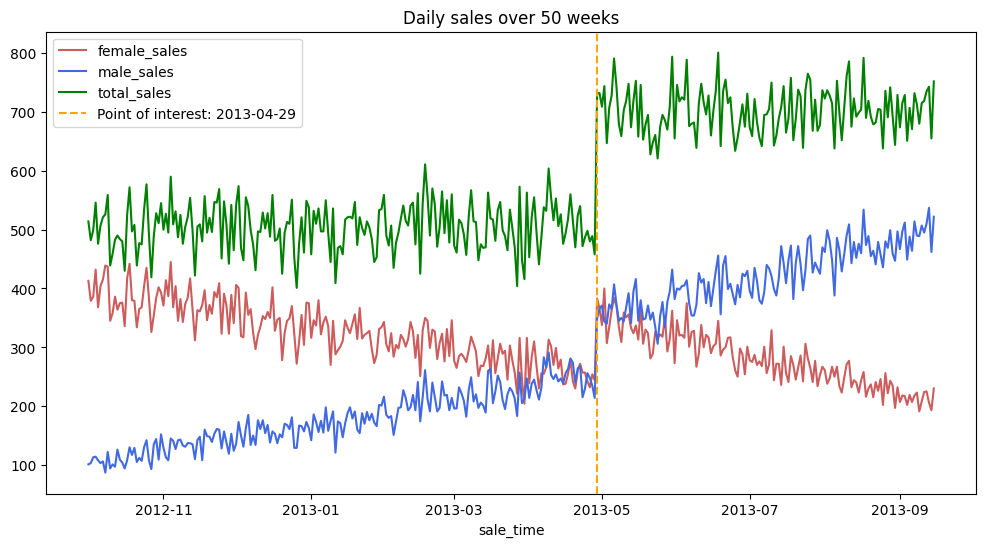

In [ ]:
# Plotting total sales, male sales, and female sales
pivot.plot(figsize=FIGSIZE, title = 'Daily sales over 50 weeks', color = ['indianred', 'royalblue', 'g'])

# Adding the vertical line at cut-off point
plt.axvline(pd.to_datetime(cut_off_point), color='orange', linestyle='--', label=f'Point of interest: {cut_off_point}')
plt.legend()
plt.show()

It can be observed that the ratio between male and female sales changes over time. In general there is a downwards trend for the female sales, while the male sales follow an upwards trend. Notably, there is a sudden increase in **both** categories at the cut-off point. Let's have a closer look at the proportion itself:

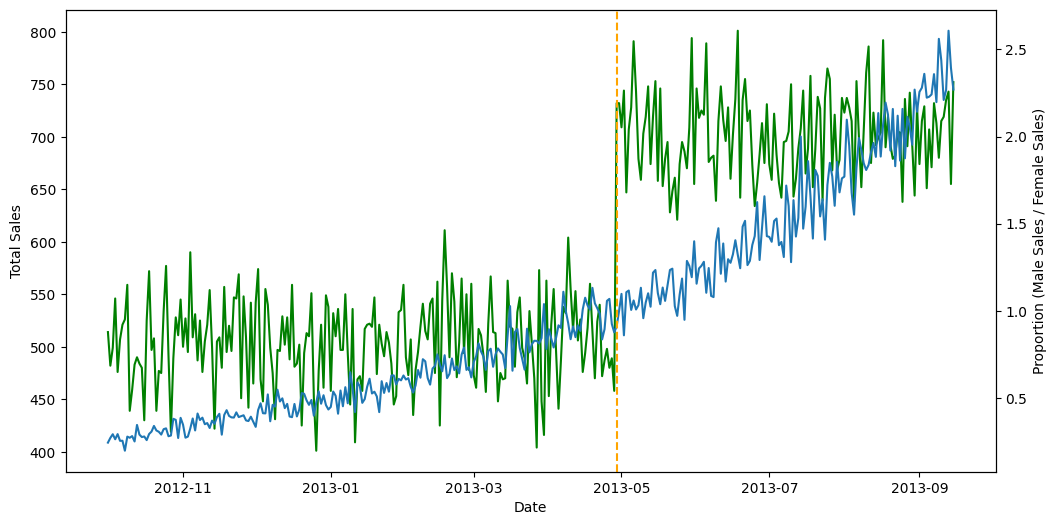

In [ ]:
# Creating a new df (copy of pivot) and calculate the proportion
proportion_df = pivot.copy()
proportion_df['proportion'] = proportion_df.male_sales / proportion_df.female_sales

# Setting up the plot
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Using two axes - one for the sales and one for the proportion
ax2 = ax1.twinx()

ax1.plot(proportion_df.index, proportion_df.total_sales, color = 'g')
ax2.plot(proportion_df.index, proportion_df.proportion)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales')
ax2.set_ylabel('Proportion (Male Sales / Female Sales)')
plt.axvline(pd.to_datetime(cut_off_point), color='orange', linestyle='--', label=f'Point of interest: {cut_off_point}')

plt.show()

The male ratio (male sales / female sales) is steadily increasing, but does not explain the sudden change in total sales. Thus, the reason must be something else!

## 5. What is the percentage of sales in each daypart over all 50 weeks?
Assume a given day is divided into four dayparts:
- night (12:00AM - 6:00AM),
- morning (6:00AM - 12:00PM),
- afternoon (12:00PM - 6:00PM),
- evening (6:00PM - 12:00AM).


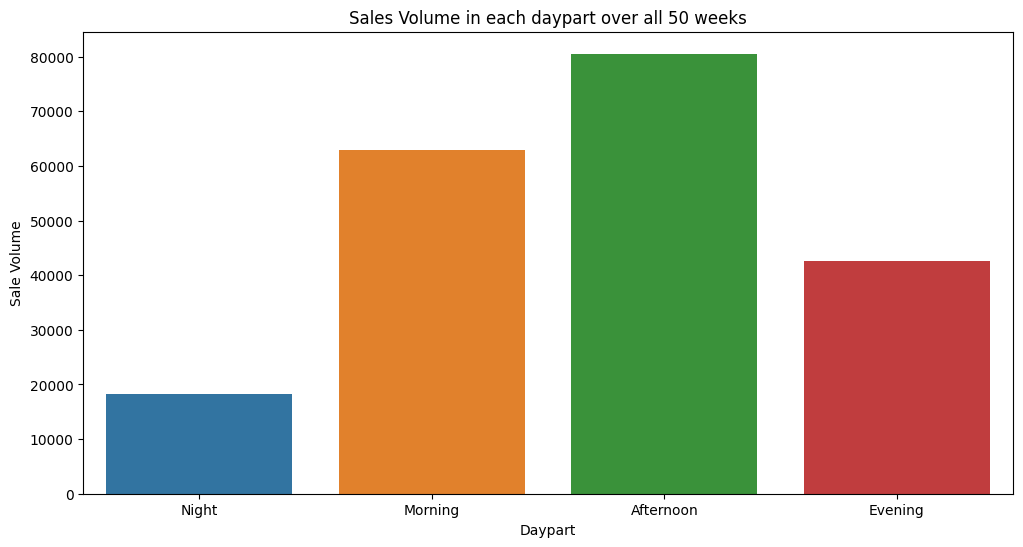

In [ ]:
def get_daypart(sale_time):
  """
  Function for determining the daypart of each entry
  """
  time = sale_time.time()
  if time >= dt.time(0, 0, 0) and time < dt.time(6, 0, 0):
      return 'Night'
  elif time >= dt.time(6, 0, 0) and time < dt.time(12, 0, 0):
      return 'Morning'
  elif time >= dt.time(12, 0, 0) and time < dt.time(18, 0, 0):
      return 'Afternoon'
  else:
      return 'Evening'

# 'Calculating' the daypart of each entry
combined_df['daypart'] = combined_df['sale_time'].apply(get_daypart)

# Grouping the df by daypart and calculating the sale volume for each
daypart_df = combined_df.groupby('daypart').size().to_frame('sale_volume').reset_index()

# Sorting the values according to the daypart
daypart_df['daypart'] = pd.Categorical(daypart_df['daypart'], ['Night', 'Morning', 'Afternoon', 'Evening'])
daypart_df = daypart_df.sort_values(by='daypart')

# Creating the barplot
plt.figure(figsize=FIGSIZE)
sns.barplot(x='daypart', y='sale_volume', data=daypart_df, hue = 'daypart', palette = sns.color_palette()[:4])
plt.title('Sales Volume in each daypart over all 50 weeks')
plt.xlabel('Daypart')
plt.ylabel('Sale Volume')
plt.show()

Most of the sales were done in the afternoon.

In [ ]:
daypart_df['day_part_sales_percentage'] = (daypart_df['sale_volume'] / daypart_df['sale_volume'].sum()) * 100

display(daypart_df)

,daypart,sale_volume,day_part_sales_percentage
3,Night,18306,8.959081
2,Morning,62870,30.769005
0,Afternoon,80533,39.413397
1,Evening,42620,20.858517
